# GraphNets (Pytorch)

## Utils

In [1]:
import itertools


def pairwise(iterable):
    """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


In [2]:
# GraphTuple
from collections import namedtuple
from functools import partial
from typing import Callable
from typing import List
from typing import Tuple
from typing import Dict

import networkx as nx
import numpy as np
import torch

GraphTuple = namedtuple(
    "GraphTuple",
    [
        "node_attr",  # node level attributes
        "edge_attr",  # edge level attributes
        "global_attr",  # global level attributes
        "edges",  # node-to-node connectivity
        "node_indices",  # tensor where each element indicates the index of the graph the node_attr belongs to
        "edge_indices",
        # tensor where each element indicates the index of the graph that the edge_attr and edges belong to.
    ],
)


def pick_edge(graphs):
    for g in graphs:
        for x in g.edges(data=True):
            if x[-1] is not None:
                return x


def pick_node(graphs):
    for g in graphs:
        for x in g.nodes(data=True):
            if x[-1] is not None:
                return x


def to_graph_tuple(
    graphs: List[nx.DiGraph],
    feature_key: str = "features",
    global_attr_key: str = "data",
    device: str = None,
) -> GraphTuple:
    """Convert a list og networkx graphs into a GraphTuple.

    :param graphs: list of graphs
    :param feature_key: key to find the node, edge, and global features
    :param global_attr_key: attribute on the NetworkX graph to find the global data (default: 'data')
    :return: GraphTuple, a namedtuple of ['node_attr', 'edge_attr', 'global_attr',
        'edges', 'node_inices', 'edge_indices']
    """
    n_edges = 0
    n_nodes = 0
    for graph in graphs:
        n_edges += graph.number_of_edges()
        n_nodes += graph.number_of_nodes()

    n = len(graphs)
    node_idx = np.empty(n_nodes)
    edge_idx = np.empty(n_edges)


    edge = pick_edge(graphs)
    if edge:
        edata = edge[-1][feature_key]
    else:
        edata = np.empty(1)

    node = pick_node(graphs)
    if node:
        vdata = node[-1][feature_key]
    else:
        vdata = np.empty(1)

    if hasattr(graph, global_attr_key):
        udata = getattr(graph, global_attr_key)[feature_key]
    else:
        udata = np.zeros(1)

    connectivity = np.empty((n_edges, 2))

    v = np.empty((n_nodes, *tuple(vdata.shape)))
    e = np.empty((n_edges, *tuple(edata.shape)))
    u = np.empty((n, *tuple(udata.shape)))

    _v = 0
    _e = 0

    ndict = {}

    for gidx, graph in enumerate(graphs):
        for node, ndata in graph.nodes(data=True):
            v[_v] = ndata[feature_key]
            ndict[node] = _v
            node_idx[_v] = gidx
            _v += 1

        for n1, n2, edata in graph.edges(data=True):
            e[_e] = edata[feature_key]
            edge_idx[_e] = gidx
            connectivity[_e] = [ndict[n1], ndict[n2]]
            _e += 1

        if hasattr(graph, global_attr_key):
            u[gidx] = getattr(graph, global_attr_key)[feature_key]
        else:
            u[gidx] = 0

    result = GraphTuple(
        torch.tensor(v, dtype=torch.float),
        torch.tensor(e, dtype=torch.float),
        torch.tensor(u, dtype=torch.float),
        torch.tensor(connectivity, dtype=torch.long),
        torch.tensor(node_idx, dtype=torch.long),
        torch.tensor(edge_idx, dtype=torch.long),
    )
    if device:
        return GraphTuple(*[x.to(device) for x in result])
    return result


def from_graph_tuple(gt: GraphTuple, feature_key: str = 'features') -> Dict[int, nx.DiGraph]:

    graph_dict = {}

    for node, (gidx, ndata) in enumerate(zip(gt.node_indices, gt.node_attr)):
        graph_dict.setdefault(gidx.item(), nx.DiGraph())
    g = graph_dict[gidx.item()]
    g.add_node(node, **{'features': ndata})

    for gidx, (n1, n2), edata in zip(gt.edge_indices, gt.edges, gt.edge_attr):
        graph_dict.setdefault(gidx.item(), nx.DiGraph())
    g = graph_dict[gidx.item()]
    g.add_edge(n1.item(), n2.item(), **{'features': edata})

    return graph_dict


def collate_tuples(tuples: List[Tuple], func: Callable[[List[Tuple]], Tuple]):
    """Collate elements of many tuples using a function. All of the first
    elements for all the tuples will be collated using the function, then all
    of the second elements of all tuples, and so on.

    :param tuples: list of tuples
    :param func: callable
    :return: tuple of same type
    """

    def f(x):
        if x is None:
            return None
        else:
            return func(x)

    t = type(tuples[0])
    if t is tuple:

        def t(*args):
            return tuple(args)

    return t(*[f(x) for x in zip(*tuples)])


def replace_key(graph_tuple, data: dict):
    """Replace the values of the graph tuple.

    DOES NOT REPLACE IN PLACE.
    """
    values = []
    for k, v in zip(graph_tuple._fields, graph_tuple):
        if k in data:
            v = data[k]
        values.append(v)
    return GraphTuple(*values)


def apply_to_tuple(x, func: Callable[[List[Tuple]], Tuple]):
    """Apply function to each element of the tuple."""
    return type(x)(*[func(x) for x in x])


def print_graph_tuple_shape(graph_tuple):
    for field, x in zip(graph_tuple._fields, graph_tuple):
        print(field, "  ", x.shape)


def cat_gt(*gts: Tuple[GraphTuple, ...]) -> GraphTuple:
    """Concatenate graph tuples along dimension=1.

    Edges, node idx and edge idx are simply copied over.
    """
    cat = partial(torch.cat, dim=1)
    return GraphTuple(
        cat([gt.node_attr for gt in gts]),
        cat([gt.edge_attr for gt in gts]),
        cat([gt.global_attr for gt in gts]),
        gts[0].edges,
        gts[0].node_indices,
        gts[0].edge_indices,
    )


def gt_to_device(x: Tuple, device):
    return GraphTuple(*[v.to(device) for v in x])


class InvalidGraphTuple(Exception):
    pass


def validate_gt(gt: GraphTuple):
    if not isinstance(gt, GraphTuple):
        raise InvalidGraphTuple("{} is not a {}".format(gt, GraphTuple))

    if not gt.edge_attr.shape[0] == gt.edges.shape[0]:
        raise InvalidGraphTuple(
            "Edge attribute shape {} does not match edges shape {}".format(
                gt.edge_attr.shape, gt.edges.shape
            )
        )

    if not gt.edge_attr.shape[0] == gt.edge_indices.shape[0]:
        raise InvalidGraphTuple(
            "Edge attribute shape {} does not match edge idx shape {}".format(
                gt.edge_attr.shape, gt.edge_indices.shape
            )
        )

    if not gt.node_attr.shape[0] == gt.node_indices.shape[0]:
        raise InvalidGraphTuple(
            "Node attribute shape {} does not match node idx shape {}".format(
                gt.node_attr.shape, gt.node_indices.shape
            )
        )

    # edges cannot refer to non-existent nodes
    if gt.edges.shape[0] and not (gt.edges.max().item() < gt.node_attr.shape[0]):
        raise InvalidGraphTuple(
            "Edges reference node {} which does not exist nodes of size {}".format(
                gt.edges.max(), gt.node_attr.shape[0]
            )
        )

    if gt.edges.shape[0] and not (gt.edges.min().item() >= 0):
        raise InvalidGraphTuple(
            "Node index must be greater than 0, not {}".format(gt.edges.min())
        )


## Data

In [102]:
from torch.utils.data import DataLoader

class GraphMask(object):
    
    def __init__(self, node_mask, edge_mask, global_mask):
        self.x_mask = node_mask,
        self.e_mask = edge_mask
        self.g_mask = global_mask
    

class GraphData(object):
    """Data representing a single graph"""
    __slots__ = ['x', 'e', 'g', 'edges']
    def __init__(self, node_attr, edge_attr, global_attr, edges):
        self.x = node_attr
        self.e = edge_attr
        self.g = global_attr
        self.edges = edges
        GraphData.debug(self)
        
    def debug(self):
        if self.edges.max() >= self.x.shape[0]:
            raise RuntimeError("Edge coordinate {} is greater than number of nodes {}".format(self.edges.max(), self.x.shape[0
                                                                                                                            ]))
        if not self.edges.shape[1] == self.e.shape[0]:
            raise RuntimeError("Number of edges {} must match number of edge attributes {}".format(
                self.edges.shape[1],
                self.e.shape[0]
            ))
            
        if not self.edges.dtype == torch.long:
            raise RunTimeError("Wrong tensor type. `edges` must be dtype={} not {}".format(self.edges.dtype, torch.long))

            
    def apply(self, func):
        for f in self.__slots__:
            func(f)
            
    def to(self, device: str):
        self.apply(lambda x: x.to(device))
        
    def contiguous(self):
        self.apply(lambda x: x.contiguous())
            
    @property
    def num_graphs(self):
        return self.g.shape[0]
    
    @property
    def num_nodes(self):
        return self.x.shape[0]
    
    @property
    def node_shape(self):
        return self.x.shape[1:]
    
    @property
    def edge_shape(self):
        return self.e.shape[1:]
    
    @property
    def global_shape(self):
        return self.g.shape[1:]
    
    @property
    def shape(self):
        return self.x.shape[1:] + self.e.shape[1:] + self.g.shape[1:]
    
    @property
    def size(self):
        return self.x.shape[:1] + self.e.shape[:1] + self.g.shape[:1]
    
            
    def _mask_fields(self, masks: Dict[str, torch.tensor]):
        for m in masks:
            if m not in self.__slots__:
                raise RuntimeError("{} is not a valid field".format(m))
        masked_fields = []
        for field in self.__slots__:
            if field not in masks or masks[field] is None:
                masked_fields.append(getattr(self, field))
            else:
                masked_fields.append(getattr(self, field)[:, masks[field]])
        return masked_fields
    
    def mask(self, node_mask, edge_mask, global_mask, invert: bool = False):
        d = {'x': node_mask, 'e': edge_mask, 'g': global_mask}
        if invert:
            d = {k: ~v for k, v in d.items()}
        return self.__class__(
            *self._mask_fields(d)
        )
    
    def clone(self):
        return self.__class__(
            *[getattr(self, field).clone() for field in self.__class__.__slots__]
        )
        
    def __repr__(self):
        return "<{cls} size(n,e,g)={size} features(n,e,g)={shape}>".format(
            cls=self.__class__.__name__,
            n_graphs=self.num_graphs,
            size=self.x.shape[:1] + self.e.shape[:1] + self.g.shape[:1],
            shape=self.shape
        )
        
class GraphBatch(GraphData):
    __slots__ = GraphData.__slots__ + ['node_idx', 'edge_idx']
    
    def __init__(self, node_attr, edge_attr, global_attr, edges, node_idx, edge_idx):
        super(GraphBatch, self).__init__(node_attr, edge_attr, global_attr, edges)
        self.node_idx = node_idx
        self.edge_idx = edge_idx
        GraphBatch.debug(self)
    
    
    @staticmethod
    def _same(a):
        return min(a) == max(a)
        
    def debug(self):
        super().debug()
        if not self.node_idx.dtype == torch.long:
            raise RunTimeError("Wrong tensor type. `node_idx` must be dtype={} not {}".format(self.node_idx.dtype, torch.long))
        if not self.edge_idx.dtype == torch.long:
            raise RunTimeError("Wrong tensor type. `edge_idx` must be dtype={} not {}".format(self.edge_idx.dtype, torch.long))
        if not self.node_idx.max() == self.edge_idx.max():
            raise RuntimeError("Number of graphs in node_idx and edge_idx mismatch")
        if not self.node_idx.min() == 0:
            raise RuntimeError("Minimum graph index (node_idx.min()) must start at 0, not {}".format(self.node_idx.min()))
        if not self.edge_idx.min() == 0:
            raise RuntimeError("Minimum graph index (edge_idx.min()) must start at 0, not {}".format(self.edge_idx.min()))
        
    @classmethod
    def from_data_list(cls, data_list):
        # checks
        n_features = []
        e_features = []
        g_features = []
        for data in data_list:
            n_features.append(data.x.shape[1])
            e_features.append(data.e.shape[1])
            g_features.append(data.g.shape[0])
        if not cls._same(n_features):
            raise RuntimeError("Node feature dimensions must all be the same")
        if not cls._same(e_features):
            raise RuntimeError("Edge feature dimensions must all be the same")
        if not cls._same(g_features):
            raise RuntimeError("Global feature dimensions must all be the same")
        
        node_repeats = torch.tensor([data.x.shape[0] for data in data_list])
        edge_repeats = torch.tensor([data.e.shape[0] for data in data_list])
        node_idx = torch.repeat_interleave(torch.range(0, node_repeats.shape[0]-1, dtype=torch.long), node_repeats)
        edge_idx = torch.repeat_interleave(torch.range(0, edge_repeats.shape[0]-1, dtype=torch.long), edge_repeats)
        
        # concatenate edges
        edges = torch.cat([data.edges for data in data_list], dim=1)
        
        # cumulated shapes
        c = torch.cumsum(torch.tensor([0] + [data.x.shape[0] for data in data_list[:-1]]), dim=0)
        delta = torch.repeat_interleave(c, edge_repeats).repeat(2, 1)
        
        # shift concatenated edges
        edges = edges + delta
        
        return cls(
            node_attr=torch.cat([data.x for data in data_list]),
            edge_attr=torch.cat([data.e for data in data_list]),
            global_attr = torch.cat([data.g for data in data_list]),
            edges=edges,
            node_idx=node_idx,
            edge_idx=edge_idx
        )
    
                
#     def mask(self, node_mask = None, edge_mask = None, global_mask = None):
#         masked = self._mask_fields({'x': node_mask, 'e': edge_mask, 'g': global_mask})
#         return self.__class__(*masked)

#     def __repr__(self):
#         return "<{cls} size(n,e,g)={size} features(n,e,g)={shape}>".format(
#             cls=self.__class__.__name__,
#             n_graphs=self.num_graphs,
#             size=self.x.shape[:1] + self.e.shape[:1] + self.g.shape[:1],
#             shape=self.shape
#         )

data1 = GraphData(
    torch.randn(10, 5),
    torch.randn(3, 4),
    torch.randn(1, 3),
    torch.randint(0, 10, torch.Size([2, 3]))
)

data2 = GraphData(
    torch.randn(10, 5),
    torch.randn(5, 4),
    torch.randn(1, 3),
    torch.randint(0, 10, torch.Size([2, 5]))
)

batch = GraphBatch.from_data_list([data1, data2])

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


In [103]:
def foo(*args):
    print(*args)

foo(*(3,2,3), *(3,))

3 2 3 3


In [104]:
# test clone
data1.clone()
batch.clone()

<GraphBatch size(n,e,g)=torch.Size([20, 8, 2]) features(n,e,g)=torch.Size([5, 4, 3])>

In [105]:
# test masks
data1.mask(
    torch.tensor([True, True, False, False, False]),
    torch.tensor([True, True, False, False]),
    torch.tensor([True, False, False])
)

batch.mask(
    torch.tensor([True, True, False, False, False]),
    torch.tensor([True, True, False, False]),
    torch.tensor([True, False, False])
)

<GraphBatch size(n,e,g)=torch.Size([20, 8, 2]) features(n,e,g)=torch.Size([2, 2, 1])>

In [106]:
def random_data(n_features, e_features, g_features):
    n_nodes = torch.randint(1, 10, torch.Size([])).item()
    n_edges = torch.randint(1, 20, torch.Size([])).item()
    return GraphData(
        torch.randn(n_nodes, n_features),
        torch.randn(n_edges, e_features),
        torch.randn(1, g_features),
        torch.randint(0, n_nodes, torch.Size([2, n_edges]))
    )

random_data(5, 3, 4)

<GraphData size(n,e,g)=torch.Size([7, 14, 1]) features(n,e,g)=torch.Size([5, 3, 4])>

In [107]:
from torch.utils.data import DataLoader

def collate(data_list):
    if isinstance(data_list[0], tuple):
        if issubclass(type(data_list[0][0]), GraphData):
            return tuple([collate([x[i] for x in data_list]) for i in range(len(data_list[0]))])
        else:
            raise RuntimeError("Cannot collate {}({})({})".format(type(data_list), type(data_list[0]), type(data_list[0][0])))
    return GraphBatch.from_data_list(data_list)
    
class GraphDataLoader(DataLoader):
    

    def __init__(self, dataset, batch_size=1, shuffle=False,
                 **kwargs):
        super().__init__(dataset, batch_size, shuffle,
                             collate_fn=collate, **kwargs)

In [108]:
data_list = [random_data(5, 4, 3) for _ in range(2000)]

# test data list loader
loader = GraphDataLoader(data_list)
for s in loader:
    pass


# test data list loader of tuples
loader = GraphDataLoader(list(zip(data_list, data_list)))
for s in loader:
    pass

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


### From Networkx

In [293]:
def pick_edge(graph):
    for x in g.edges(data=True):
        if x[-1] is not None:
            return x


def pick_node(graph):
    for x in g.nodes(data=True):
        if x[-1] is not None:
            return x

            
def to_graph_data(
    graph, 
    feature_key: str = "features",
    global_attr_key: str = "data",
    device: str = None,
) -> GraphTuple:
    """Convert a list og networkx graphs into a GraphTuple.

    :param graphs: list of graphs
    :param feature_key: key to find the node, edge, and global features
    :param global_attr_key: attribute on the NetworkX graph to find the global data (default: 'data')
    :return: GraphTuple, a namedtuple of ['node_attr', 'edge_attr', 'global_attr',
        'edges', 'node_inices', 'edge_indices']
    """
    n_edges = graph.number_of_edges()
    n_nodes = graph.number_of_nodes()

    edge = pick_edge(graph)
    print(edge)
    if edge:
        edata = edge[-1][feature_key]
    else:
        edata = np.empty(1)

    node = pick_node(graph)
    if node:
        vdata = node[-1][feature_key]
    else:
        vdata = np.empty(1)

    if hasattr(graph, global_attr_key):
        udata = getattr(graph, global_attr_key)[feature_key]
    else:
        udata = np.zeros(1)

    connectivity = np.empty((n_edges, 2))

    print([type(v) for v in edge[-1].values()])
    
    v = np.empty((n_nodes, *tuple(vdata.shape)))
    e = np.empty((n_edges, *tuple(edata.shape)))
    u = np.empty((n, *tuple(udata.shape)))

    _v = 0
    _e = 0

    ndict = {}

    for node, ndata in graph.nodes(data=True):
        v[_v] = ndata[feature_key]
        ndict[node] = _v
        _v += 1

    for n1, n2, edata in graph.edges(data=True):
        e[_e] = edata[feature_key]
        connectivity[_e] = [ndict[n1], ndict[n2]]
        _e += 1

    if hasattr(graph, global_attr_key):
        u[gidx] = getattr(graph, global_attr_key)[feature_key]
    else:
        u[gidx] = 0

    return GraphData(
        v, e, u, connectivity
    )


GraphType = None

def add_features(
    g: GraphType,
    n_feat_gen: Callable[[], Any],
    e_feat_gen: Callable[[], Any],
    g_feat_gen: Callable[[], Any],
    attribute_name: str = "features",
):
    """Add features to a graph.

    :param g:
    :param n_feat_gen:
    :param e_feat_gen:
    :param g_feat_gen:
    :param attribute_name:
    :return:
    """
    for _, ndata in g.nodes(data=True):
        ndata[attribute_name] = n_feat_gen()
        print(ndata[attribute_name])
    for _, _, edata in g.edges(data=True):
        edata[attribute_name] = e_feat_gen()
        print(edata[attribute_name])
    if not hasattr(g, "data"):
        g.data = {}
    g.data.update({attribute_name: g_feat_gen()})

    return g
    
def random_graph_generator(
    n_nodes: Union[int, Callable[[], int]],
    theta: int,
    n_feat_gen: Callable[[], Any],
    e_feat_gen: Callable[[], Any],
    g_feat_gen: Callable[[], Any],
    attribute_name: str = "features",
) -> Generator[nx.DiGraph, None, None]:
    def _resolve(x):
        if callable(x):
            return x()
        return x

    while True:
        n_nodes = _resolve(n_nodes)
        _theta = _resolve(theta)
        g = nx.geographical_threshold_graph(n_nodes, _theta)
        return g
        dg = nx.DiGraph()
        dg.add_edges_from(g.edges)
        add_features(
            dg, n_feat_gen, e_feat_gen, g_feat_gen, attribute_name=attribute_name
        )
        yield dg

        
generator = random_graph_generator(
    lambda: np.random.randint((2, 30)),
    20,
    lambda: None,
    lambda: None,
    lambda: np.random.uniform(0, 10, (5))
)

graph = next(generator)
for _, ndata in graph.nodes(data=True):
    print(_)
    print(ndata)

StopIteration: 

In [264]:
print(np.random.uniform(0, 10, (4)))

[7.82338876 4.21026056 0.66954272 6.34999034]


## Blocks

### Common Blocks

In [3]:
from functools import wraps
from typing import *
import torch
import torch_scatter
from torch import nn


class MLPBlock(nn.Module):
    """A multilayer perceptron block."""

    def __init__(self, input_size: int, output_size: int = None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.blocks = nn.Sequential(
            nn.Linear(input_size, output_size), nn.ReLU(), nn.LayerNorm(output_size)
        )

    def forward(self, x):
        return self.blocks(x)


class BlockRepeat(nn.Module):
    """A repeating block"""
    
    def __init__(self, module: nn.Module, *latent_sizes: List[int]):
        super().__init__()
        self.blocks = nn.Sequential(
            *[module(n1, n2) for n1, n2 in pairwise(latent_sizes)]
        )
        
    def forward(self, x):
        return self.blocks(x)
    
class MLP(BlockRepeat):
    """
    Repeating MLP block
    
    Usage:
    .. code-block:: python
    
        MLP([10, 16, 10])
    """
    def __init__(self, *latent_sizes: List[int]):
        for size in latent_sizes:
            assert isinstance(size, int)
        super().__init__(MLPBlock, *latent_sizes)
        

class Aggregator(nn.Module):
    """Aggregation layer."""

    def __init__(self, aggregator: str, dim: int = None, dim_size: int = None):
        super().__init__()

        self.valid_aggregators = {
            "mean": torch_scatter.scatter_mean,
            "max": self.scatter_max,
            "min": self.scatter_min,
            "add": torch_scatter.scatter_add,
        }

        if aggregator not in self.valid_aggregators:
            raise ValueError(
                "Aggregator '{}' not not one of the valid aggregators {}".format(
                    aggregator, self.valid_aggregators
                )
            )
        self.aggregator = aggregator
        self.kwargs = dict(dim=dim, dim_size=dim_size)

    def forward(self, x, indices, **kwargs):
        func_kwargs = dict(self.kwargs)
        func_kwargs.update(kwargs)
        func = self.valid_aggregators[self.aggregator]
        result = func(x, indices, **func_kwargs)
        return result

    @staticmethod
    @wraps(torch_scatter.scatter_max)
    def scatter_max(*args, **kwargs):
        return torch_scatter.scatter_max(*args, **kwargs)[0]

    @staticmethod
    @wraps(torch_scatter.scatter_min)
    def scatter_min(*args, **kwargs):
        return torch_scatter.scatter_min(*args, **kwargs)[0]


class Block(nn.Module):
    def __init__(self, module_dict: Dict[str, nn.Module], independent: bool):
        super().__init__()
        self._independent = independent
        self.block_dict = nn.ModuleDict(
            {name: mod for name, mod in module_dict.items() if mod is not None}
        )

    @property
    def out_dim(self):
        pass

### Flexible Blocks

In [4]:
from functools import wraps
from typing import Any
from typing import Dict
from typing import Tuple
from typing import Type

import torch


class FlexDim:
    def __init__(self, pos: int = 0, dim: int = 1):
        """Flexible dimension to be used in conjunction with `FlexBlock`

        :param pos: position of the input arguments that contains the input data
        :param dim: dimension to use for the input shape
        """
        self.pos = pos
        self.dim = dim

    def resolve(self, input_args, input_kwargs):
        d = input_args[self.pos].shape[self.dim]
        if d == 0:
            raise ValueError("Dimension cannot be zero")
        return d


class FlexBlock(torch.nn.Module):
    def __init__(self, module_fn, *args, **kwargs):
        super().__init__()
        self.module = module_fn
        self.args = args
        self.kwargs = kwargs
        self.resolved_module = None

    def resolve_args(self, input_args: Tuple[Any, ...], input_kwargs: Dict[str, Any]):
        rargs = []
        for i, a in enumerate(self.args):
            if isinstance(a, FlexDim):
                rargs.append(a.resolve(input_args, input_kwargs))
            elif a is FlexDim:
                raise ValueError("Found {}. Initialize FlexDim to use flexible dimensions, `Flex.d()` or `FlexDim()`".format(
                a))
            else:
                rargs.append(a)
        return rargs

    def resolve_kwargs(self, input_args: Tuple[Any, ...], input_kwargs: Dict[str, Any]):
        return self.kwargs

    def resolve(self, args: Tuple[Any, ...], kwargs: Dict[str, Any]):
        resolved_args = self.resolve_args(args, kwargs)
        resolved_kwargs = self.resolve_kwargs(args, kwargs)
        self.resolved_module = self.module(*resolved_args, **resolved_kwargs)

    def forward(self, *args, **kwargs):
        if self.resolved_module is None:
            self.resolve(args, kwargs)
        return self.resolved_module(*args, **kwargs)


class Flex:
    d = FlexDim

    def __init__(self, module_type: Type[torch.nn.Module]):
        """Initialize a module as a FlexBlock with flexible dimensions.

        Usage:

        .. code-block:: python

            Flex(torch.nn.Linear)(Flex.d(), 25)

        :param module_type: module type (e.g. `torch.nn.Linear`
        """
        self.module_type = module_type

        self.__call__ = wraps(module_type.__init__)(self.__class__.__call__)

    def __call__(self, *args, **kwargs) -> torch.nn.Module:
        """Initialize the flexible module.

        :param args: the initialization arguments
        :param kwargs: the initialization keyword arguments
        :return: initialized torch.nn.Module
        """
        return FlexBlock(self.module_type, *args, **kwargs)


In [5]:
Flex(MLP)(Flex.d(), 16, 10)(torch.randn(10, 5))

tensor([[-0.5750, -0.5750, -0.5750,  0.3749, -0.5750, -0.5750, -0.5750, -0.5750,
          2.4887,  1.1616],
        [ 1.3155, -0.7827, -0.7944, -0.4670,  0.2034, -0.7944, -0.7944, -0.7944,
          2.0208,  0.8875],
        [-0.0606, -0.6886,  2.0214, -0.9019, -0.4421, -0.9019,  0.6446, -0.9019,
         -0.2863,  1.5171],
        [-0.6187, -0.8845,  1.3538, -0.0050, -0.8845,  0.4454,  0.1302, -0.8845,
         -0.7946,  2.1423],
        [ 0.9987, -0.0050,  0.8328, -1.2652,  1.6572, -1.2652, -0.1878, -1.2652,
         -0.2965,  0.7962],
        [ 0.3668, -0.9021,  1.1670, -1.2332,  1.1612, -1.2332,  1.0466, -1.2332,
          0.8221,  0.0382],
        [ 0.7668,  0.1514,  0.0880, -1.0120,  0.8601, -1.0120, -1.0120, -1.0120,
          2.1311,  0.0503],
        [ 0.4537, -0.7915,  0.5002, -0.7915, -0.2991, -0.7915, -0.7915, -0.7915,
          0.9936,  2.3093],
        [-0.7814, -0.7814,  1.5628, -0.7814, -0.7814,  0.3917,  1.3362, -0.7814,
         -0.7814,  1.3979],
        [ 1.1794, -

### Graph Blocks

In [6]:
class EdgeBlock(Block):
    def __init__(self, mlp: nn.Module, independent: bool):
        super().__init__({"mlp": mlp}, independent=independent)

    def forward(self, edge_attr: torch.tensor, src: torch.tensor = None, dest: torch.tensor = None):
        if not self._independent:
            out = torch.cat([src, dest, edge_attr], 1)
        else:
            out = edge_attr
        results = self.block_dict["mlp"](out)
        return results


# TODO: concatenate global features for Edge and Node block


class NodeBlock(Block):
    def __init__(
        self, mlp: nn.Module, independent: bool, edge_aggregator: Aggregator = None
    ):
        """

        :param input_size:
        :param layers:
        :param edge_aggregator:
        :param independent:
        """
        super().__init__(
            {"edge_aggregator": edge_aggregator, "mlp": mlp}, independent=independent
        )

    def forward(self, v, edge_index, edge_attr, u, node_idx, edge_idx):
        if not self._independent:
            row, col = edge_index
            aggregator_fn = self.block_dict["edge_aggregator"]
            if aggregator_fn:
                aggregated = self.block_dict["edge_aggregator"](
                    edge_attr, col, dim=0, dim_size=v.size(0)
                )
                out = torch.cat([aggregated, v], dim=1)
            else:
                out = torch.cat([v], dim=1)
        else:
            out = v
        return self.block_dict["mlp"](out)


class GlobalBlock(Block):
    def __init__(
        self,
        mlp,
        independent: bool,
        node_aggregator: Aggregator = None,
        edge_aggregator: Aggregator = None,
    ):
        super().__init__(
            {
                "node_aggregator": node_aggregator,
                "edge_aggregator": edge_aggregator,
                "mlp": mlp,
            },
            independent=independent,
        )

    def forward(self, node_attr, edge_index, edge_attr, u, node_idx, edge_idx):
        if not self._independent:
            node_agg = self.block_dict["node_aggregator"]
            edge_agg = self.block_dict["edge_aggregator"]
            to_cat = [u]
            if node_agg is not None:
                to_cat.append(node_agg(node_attr, node_idx, dim=0, dim_size=u.shape[0]))
            if edge_agg is not None:
                to_cat.append(edge_agg(edge_attr, edge_idx, dim=0, dim_size=u.shape[0]))
            try:
                out = torch.cat(to_cat, dim=1)
            except RuntimeError as e:
                raise e
        else:
            out = u
        return self.block_dict["mlp"](out)

## Models

In [7]:
class Block(nn.Module):
    def __init__(self, module_dict: Dict[str, nn.Module], independent: bool):
        super().__init__()
        self._independent = independent
        self.block_dict = nn.ModuleDict(
            {name: mod for name, mod in module_dict.items() if mod is not None}
        )
        
    @property
    def independent(self):
        return self._independent

### Edge Block

In [153]:
class EdgeBlock(Block):
    def __init__(self, mlp: nn.Module):
        super().__init__({"mlp": mlp}, independent=True)

    def forward(self, edge_attr: torch.tensor, node_attr: torch.tensor = None, edges: torch.tensor = None):
        results = self.block_dict["mlp"](edge_attr)
        return results
    
    def forward_from_data(self, data: GraphData):
        return self(data.e, data.x, data.edges)
    
class AggregatingEdgeBlock(EdgeBlock):
    
    def __init__(self, mlp: nn.Module):
        super().__init__(mlp)
        self._independent = False
        
    def forward(self, edge_attr: torch.tensor, node_attr: torch.tensor, edges: torch.tensor):
        out = torch.cat([node_attr[edges[0]], node_attr[edges[1]], edge_attr], 1)
        return self.block_dict['mlp'](out)

    def forward_from_data(self, data: GraphData):
        return self(data.e, data.x. data.edges)

In [154]:
# demonstrate independent edge block
edge_encoder = EdgeBlock(MLP(3, 10, 16))

x = torch.randn(20, 3)
out = edge_encoder(x)
print(out.shape)
assert out.shape == torch.Size([20, 16])

for p in edge_encoder.parameters():
    print(p)
    print(p.requires_grad)

torch.Size([20, 16])
Parameter containing:
tensor([[ 0.1210, -0.2277,  0.1889],
        [-0.1365,  0.5003,  0.5570],
        [ 0.3130, -0.3903, -0.1930],
        [ 0.3277,  0.3244,  0.4886],
        [ 0.3342, -0.3336, -0.4264],
        [ 0.1558,  0.2876,  0.1220],
        [ 0.5439,  0.1436, -0.1355],
        [-0.0765,  0.1766, -0.2424],
        [ 0.0256,  0.0180, -0.1316],
        [ 0.0530,  0.2031,  0.4722]], requires_grad=True)
True
Parameter containing:
tensor([ 0.1202, -0.4073,  0.5615,  0.0934, -0.5129, -0.5065, -0.2680,  0.1373,
        -0.5282, -0.5753], requires_grad=True)
True
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
True
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
True
Parameter containing:
tensor([[ 0.0767, -0.0632, -0.0806,  0.2887,  0.2593, -0.2995,  0.1431,  0.2586,
          0.1206,  0.1562],
        [-0.3039, -0.1763,  0.2365,  0.3153, -0.0692,  0.1256, -0.3161, -0.1811,
   

In [155]:
# demonstrate dependent edge block
edge_model = AggregatingEdgeBlock(MLP(7, 10, 16))

x = torch.randn(20, 3)
edges = torch.randint(0, 40, torch.Size([2, 20]))
n = torch.randn(40, 2)

assert edge_model(x, n, edges).shape == torch.Size([20, 16])

for p in edge_model.parameters():
    print(p)
    print(p.requires_grad)

Parameter containing:
tensor([[ 0.2603,  0.3397,  0.2198, -0.1517, -0.1505,  0.3331, -0.3603],
        [ 0.1349,  0.2654, -0.0453, -0.1740,  0.0101, -0.2452,  0.3737],
        [ 0.1443,  0.2641, -0.0652,  0.0694,  0.3387,  0.3479, -0.0790],
        [-0.1209, -0.3372, -0.3207, -0.2977, -0.2426,  0.1312,  0.0574],
        [ 0.1141, -0.0501,  0.2595, -0.0290,  0.0012,  0.2336, -0.1119],
        [ 0.3169, -0.2901,  0.2682, -0.3079, -0.3133,  0.0336, -0.2526],
        [-0.1942, -0.3319,  0.3210,  0.1685, -0.2530,  0.3309, -0.0777],
        [ 0.0942, -0.0599, -0.1998,  0.1376, -0.2077,  0.1838,  0.3667],
        [-0.3662, -0.2241, -0.2068,  0.3638, -0.3096,  0.1646, -0.0555],
        [-0.3647,  0.1395,  0.0505, -0.1351,  0.3671, -0.0322,  0.3769]],
       requires_grad=True)
True
Parameter containing:
tensor([-0.1333,  0.2620, -0.1344,  0.0771,  0.0253,  0.2329,  0.2228, -0.0532,
        -0.3712,  0.2751], requires_grad=True)
True
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1.,

### Node Block

In [210]:
# TODO: this is redundent with EdgeBlock
class NodeBlock(Block):
    
    def __init__(self, mlp: nn.Module):
        super().__init__({
            'mlp': mlp
        }, independent=True)
        
    def forward(self, node_attr):
        return self.block_dict['mlp'](node_attr)
    
    def forward_from_data(self, data: GraphBatch):
        return self(data.x)
        
class AggregatingNodeBlock(NodeBlock):
    
    def __init__(self, mlp: nn.Module, edge_aggregator: Aggregator):
        super().__init__(mlp)
        self.block_dict['edge_aggregator'] = edge_aggregator
        self._independent = False
        
    # TODO: source_to_target, target_to_source
    def forward(self, node_attr, edge_attr, edges):
        aggregated = self.block_dict['edge_aggregator'](edge_attr, edges[1], dim=0, dim_size=node_attr.size(0))
        out = torch.cat([node_attr, aggregated], dim=1)
        return self.block_dict['mlp'](out)
    
    def forward_from_data(self, data: GraphBatch):
        return self(data.x, data.e, data.edges)

In [211]:
# test NodeBlock
node_encoder = NodeBlock(MLP(5, 16, 10))

node_attr = torch.randn(10, 5)

for p in node_encoder.parameters():
    print(p)
    print(p.requires_grad)

Parameter containing:
tensor([[ 0.0415, -0.2255,  0.3959, -0.2371,  0.3132],
        [-0.4447,  0.0189, -0.1937,  0.1661, -0.0989],
        [ 0.2344,  0.1449, -0.1460,  0.2910,  0.3089],
        [-0.0673, -0.1853,  0.4451, -0.1181, -0.3101],
        [-0.2107,  0.1073, -0.0223, -0.3777, -0.0830],
        [ 0.3793, -0.4469, -0.3085, -0.3886,  0.3230],
        [-0.3059, -0.0508,  0.2010, -0.1473,  0.0647],
        [-0.2071,  0.2156, -0.3562, -0.3745,  0.0550],
        [-0.3673, -0.3994, -0.1285, -0.2326, -0.2363],
        [-0.0046, -0.3040, -0.4258, -0.0683, -0.0013],
        [ 0.2390, -0.3274,  0.4248, -0.1263, -0.0064],
        [ 0.2021,  0.3762, -0.1416,  0.2931,  0.0307],
        [-0.0789, -0.1619, -0.3954,  0.0497, -0.3252],
        [ 0.3671, -0.2896, -0.1396,  0.3930, -0.1651],
        [-0.1314,  0.3070, -0.0995,  0.2760, -0.1272],
        [-0.3919, -0.3749,  0.1108, -0.0245,  0.3170]], requires_grad=True)
True
Parameter containing:
tensor([ 0.0744,  0.1699, -0.3106,  0.0919,  0.207

In [212]:
# test AggregatingNodeBlock

node_model = AggregatingNodeBlock(MLP(5, 16, 10), Aggregator('mean'))

edge_attr = torch.randn(20, 3)
edges = torch.randint(0, 40, torch.Size([2, 20]))
node_attr = torch.randn(40, 2)

node_model(node_attr, edge_attr, edges).shape

for p in node_model.parameters():
    print(p)
    print(p.requires_grad)

Parameter containing:
tensor([[ 0.0395, -0.4229,  0.1666,  0.0148, -0.0230],
        [ 0.3452,  0.3256,  0.4380,  0.3485,  0.1268],
        [-0.2162,  0.2017,  0.1234, -0.3475, -0.0540],
        [ 0.3229,  0.3563, -0.3410, -0.2279,  0.0035],
        [ 0.0703,  0.4202, -0.0106, -0.3943, -0.3227],
        [-0.3069, -0.1714,  0.1635,  0.1796, -0.0225],
        [-0.2115,  0.0412, -0.0524,  0.2951,  0.2591],
        [ 0.0262,  0.4057, -0.1711,  0.0500, -0.3743],
        [-0.2126,  0.2578, -0.1504,  0.0570,  0.1992],
        [ 0.0381,  0.0536,  0.1991,  0.1735, -0.2171],
        [ 0.3394, -0.2559,  0.0430,  0.4025, -0.0172],
        [ 0.1695, -0.4285, -0.2693,  0.1233, -0.1106],
        [-0.1676,  0.3603,  0.1322,  0.1852,  0.0827],
        [ 0.0952, -0.4425,  0.3901, -0.3136, -0.0251],
        [ 0.2190,  0.2785,  0.0032, -0.3712, -0.1018],
        [ 0.1682,  0.4006, -0.2943,  0.1237,  0.3962]], requires_grad=True)
True
Parameter containing:
tensor([ 0.0733,  0.1992,  0.0838,  0.2564,  0.121

### Global Block

In [213]:
class GlobalBlock(Block):
    
    def __init__(self, mlp):
        super().__init__({'mlp': mlp}, independent=True)
        
    def forward(self, global_attr):
        return self.block_dict['mlp'](global_attr)
    
    def forward_from_data(self, data: GraphBatch):
        return self(data.g)
    
class AggregatingGlobalBlock(GlobalBlock):
    
    def __init__(self, mlp, edge_aggregator = None, node_aggregator = None):
        super().__init__(mlp)
        self.block_dict['edge_aggregator'] = edge_aggregator
        self.block_dict['node_aggregator'] = node_aggregator
        self._independent = False
        
    def forward(self, global_attr, node_attr, edge_attr, edges, node_idx, edge_idx):
        aggregated = [global_attr]
        if 'node_aggregator' in self.block_dict:
            aggregated.append(self.block_dict['node_aggregator'](node_attr, node_idx, dim=0, dim_size=global_attr.shape[0]))
        if 'edge_aggregator' in self.block_dict:
            aggregated.append(self.block_dict['edge_aggregator'](edge_attr, edge_idx, dim=0, dim_size=global_attr.shape[0]))

        out = torch.cat(aggregated, dim=1)
        return self.block_dict['mlp'](out)
    
    def forward_from_data(self, data: GraphBatch):
        return self(data.g, data.x, data.e, data.edges, data.node_idx, data.edge_idx)

In [214]:
# test GlobalBlock

In [215]:
# test GlobalBlock
global_encoder = GlobalBlock(MLP(3, 10))

for p in global_encoder.parameters():
    print(p)
    print(p.requires_grad)
    
    
global_attr = torch.randn(10, 3)
global_encoder(global_attr).shape

for p in global_encoder.parameters():
    print(p)
    print(p.requires_grad)

Parameter containing:
tensor([[ 0.1137, -0.5075,  0.1875],
        [ 0.0115,  0.0237, -0.2954],
        [-0.0782, -0.5767, -0.1528],
        [-0.1023,  0.2091,  0.4577],
        [-0.2082, -0.2818, -0.5274],
        [ 0.2719, -0.2033, -0.3312],
        [ 0.4938,  0.0711, -0.1715],
        [ 0.3276, -0.0065,  0.3481],
        [ 0.1429,  0.1673,  0.2127],
        [ 0.2614, -0.2519,  0.4778]], requires_grad=True)
True
Parameter containing:
tensor([ 0.3094, -0.1716, -0.3223,  0.0177,  0.2516,  0.2354,  0.3013, -0.3091,
        -0.1496, -0.1958], requires_grad=True)
True
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
True
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
True
Parameter containing:
tensor([[ 0.1137, -0.5075,  0.1875],
        [ 0.0115,  0.0237, -0.2954],
        [-0.0782, -0.5767, -0.1528],
        [-0.1023,  0.2091,  0.4577],
        [-0.2082, -0.2818, -0.5274],
        [ 0.2719, -0.2033, -0

In [216]:
# test AggregatingGlobalBlock
global_attr = torch.randn(10, 3)
edge_attr = torch.randn(20, 3)
edges = torch.randint(0, 40, torch.Size([2, 20]))
node_attr = torch.randn(40, 2)
node_idx = torch.randint(0, 3, torch.Size([40]))
edge_idx = torch.randint(0, 3, torch.Size([20]))

global_model = AggregatingGlobalBlock(MLP(8, 16, 10), Aggregator('mean'), Aggregator('mean'))
out = global_model(global_attr, node_attr, edge_attr, edges, node_idx, edge_idx)

for p in global_model.parameters():
    print(p)
    print(p.requires_grad)
    

print(list(global_model.parameters()))

Parameter containing:
tensor([[ 0.0844,  0.2726,  0.3530, -0.2537, -0.0513, -0.0036, -0.0517,  0.3249],
        [-0.2423,  0.0031, -0.2746, -0.3428,  0.2316, -0.2392,  0.2171, -0.2080],
        [ 0.2511,  0.2781, -0.0325, -0.1743,  0.2901,  0.3362,  0.2684,  0.3533],
        [-0.2440,  0.2845, -0.1083,  0.3277, -0.2160,  0.1230, -0.3525,  0.3316],
        [-0.0276,  0.2362,  0.1284,  0.1309,  0.1169, -0.1952, -0.0307,  0.0665],
        [-0.0166, -0.3501, -0.2194, -0.0546,  0.1855,  0.0790,  0.1876,  0.0925],
        [ 0.1011, -0.0252, -0.2965,  0.2562, -0.1272,  0.1006, -0.2878,  0.0995],
        [ 0.0302, -0.1086,  0.2405,  0.0768,  0.0894,  0.0944,  0.2510, -0.2412],
        [ 0.2305, -0.1289, -0.1420,  0.2869, -0.2997,  0.1561, -0.3386, -0.2639],
        [ 0.2801, -0.0096,  0.1629,  0.2460, -0.2463, -0.1991,  0.0165, -0.3436],
        [-0.2775,  0.0642, -0.0376,  0.2735,  0.2795,  0.2371, -0.0206,  0.0189],
        [ 0.1669,  0.2623, -0.0308,  0.1118, -0.0868, -0.0174, -0.3181, -0.2

In [217]:
Flex(MLP)(Flex.d(), 16, 10)(torch.randn(10, 5))

tensor([[ 1.0301,  1.0350, -0.7040,  0.9306, -1.0618, -0.6074,  1.6527, -0.1515,
         -1.0618, -1.0618],
        [-0.4648, -0.4648, -0.4648, -0.4648,  2.8551, -0.4648, -0.4648, -0.4648,
         -0.1577,  0.5563],
        [-0.9876,  1.2069, -1.0044,  2.0454, -0.3080, -0.6904, -1.0044,  0.8768,
          0.0237, -0.1580],
        [ 0.3314, -0.4072, -0.4072, -0.4072,  2.9260, -0.4072, -0.4072, -0.4072,
         -0.4072, -0.4072],
        [-0.9930,  2.2020, -0.8844,  1.3840, -0.9930, -0.0537, -0.2162,  0.3370,
         -0.4685, -0.3140],
        [-0.3586,  1.1352,  0.1976,  1.5881, -1.4543, -0.5148,  1.1011,  0.4141,
         -1.1859, -0.9223],
        [-0.8060, -0.3016, -0.8060,  2.1865,  0.6385, -0.8060, -0.8060,  0.3437,
         -0.8060,  1.1631],
        [-0.7208, -0.7208,  1.8858, -0.0989,  1.7746, -0.7208, -0.7208,  0.6064,
         -0.5637, -0.7208],
        [ 1.4692,  1.3955, -0.8644,  0.4813, -0.8644, -0.8644,  1.3393, -0.3634,
         -0.8644, -0.8644],
        [ 1.3946,  

In [218]:
global_attr = torch.randn(10, 3)
edge_attr = torch.randn(20, 3)
edges = torch.randint(0, 40, torch.Size([2, 20]))
node_attr = torch.randn(40, 2)
node_idx = torch.randint(0, 3, torch.Size([40]))
edge_idx = torch.randint(0, 3, torch.Size([20]))

global_model = AggregatingGlobalBlock(Flex(MLP)(Flex.d(), 16, 10), Aggregator('mean'), Aggregator('mean'))
global_model(global_attr, node_attr, edge_attr, edges, node_idx, edge_idx)

for p in global_model.parameters():
    print(p)
    print(p.requires_grad)

Parameter containing:
tensor([[-0.1039,  0.2577,  0.0917, -0.1519,  0.3285,  0.2085,  0.2510, -0.1876],
        [-0.1499,  0.1940, -0.1223, -0.1979,  0.1337,  0.1627,  0.0564,  0.0503],
        [ 0.2134, -0.1887, -0.2915, -0.0839,  0.3250,  0.0742, -0.0978,  0.1651],
        [ 0.1400, -0.1397,  0.0870, -0.1338,  0.1105, -0.2054,  0.2051,  0.1111],
        [ 0.2668, -0.2671,  0.0512, -0.2422, -0.2981,  0.0605, -0.0396, -0.0995],
        [-0.1118, -0.0677,  0.0189,  0.2995,  0.2278,  0.0748, -0.3081,  0.0426],
        [-0.0777, -0.1214, -0.3440,  0.2172, -0.3092, -0.2643, -0.1568, -0.3197],
        [ 0.1911,  0.0018,  0.0297,  0.3271, -0.2596,  0.1593, -0.0293,  0.2933],
        [ 0.2084,  0.2120, -0.0677,  0.3511,  0.1465,  0.0101,  0.3240, -0.0227],
        [-0.2559, -0.2161, -0.1520, -0.0988,  0.2623, -0.2265, -0.2147, -0.1762],
        [ 0.1417,  0.2212, -0.3041, -0.1942, -0.1428, -0.0729, -0.0016,  0.0229],
        [ 0.3293, -0.0819, -0.1924, -0.2023,  0.2187, -0.1982,  0.2732, -0.1

In [219]:
x = torch.zeros(10)

# x.to("cuda")



In [220]:
x.contiguous()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Test False Training with Blocks

In [221]:
def edge_forward(model, data):
    return model(data.e, data.x, data.edges)
    
def node_forward(model, data):
    return model()

In [222]:
AggregatingNodeBlock.forward?

Signature: AggregatingNodeBlock.forward(self, node_attr, edge_attr, edges)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
File:      ~/IPython/Pytorch/PytorchGeometric/<ipython-input-210-4b524db9d270>
Type:      function


In [223]:
from os.path import isdir
from torch.utils.tensorboard import SummaryWriter

def new_writer(directory: str, suffix = ''):
    i = 0
    def name(index):
        return directory + "%04d" % index + suffix
    while isdir(name(i)):
        i += 1
        
    dirname = name(i)
    print("New writer at '{}'".format(dirname))
    return SummaryWriter(dirname)

### Testining on GlobalBlock

In [224]:
from tqdm.auto import tqdm

# new writer
writer = new_writer('runs/global_block')

# initialize random data
test_data = [random_data(5, 4, 3) for _ in range(1000)]
test_loader = GraphDataLoader(test_data, batch_size=32, shuffle=True)
test_mask = (
    torch.tensor([True, True, True, True, False]),
    torch.tensor([True, True, False, False]),
    torch.tensor([True, True, False])
)

# model
# model = GlobalBlock(MLP(2, 16, 1))
model = GlobalBlock(Flex(MLP)(Flex.d(), 16, 1))
model = AggregatingGlobalBlock(Flex(MLP)(Flex.d(), 16, 1), Aggregator('add'), Aggregator('add'))

# global_attr, node_attr, edge_attr, edges, node_idx, edge_idx):

for batch in test_loader:
    batch = batch.mask(*test_mask)
model(batch.g, batch.x, batch.e, batch.edges, batch.node_idx, batch.edge_idx)

# model = torch.nn.Sequential(
#     torch.nn.Linear(2, 16),
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 1),
#     torch.nn.ReLU()
# )

# setup initializer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

#training
for epoch in tqdm(range(100)):
    
    running_loss = 0.
    for batch_idx, batch in enumerate(test_loader):
        test_data = batch.mask(*test_mask)
        target_data = batch.mask(*test_mask, invert=True)
        
        out = model(test_data.g, test_data.x, test_data.e, test_data.edges, test_data.node_idx, test_data.edge_idx)
        loss = loss_fn(out, target_data.g)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    writer.add_scalar('test loss', running_loss, epoch)
    
    if epoch % 1 == 0:
        k = 'block_dict.mlp.resolved_module.blocks.0.blocks.0.weight'
        writer.add_histogram(k, model.state_dict()[k])

New writer at 'runs/global_block0020'


/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


In [225]:
model.state_dict()

OrderedDict([('block_dict.mlp.resolved_module.blocks.0.blocks.0.weight',
              tensor([[-2.8731e-02,  2.1540e-02, -8.1139e-02,  7.7527e-02, -5.7298e-02,
                       -2.4970e-02,  9.1070e-02, -3.6207e-02],
                      [-2.6120e-02,  1.5994e-02, -5.6311e-02,  2.9350e-02, -4.0974e-03,
                       -5.7054e-03,  8.1630e-02, -1.6967e-02],
                      [-1.7266e-03, -5.8371e-02, -2.3823e-02, -4.3910e-02, -1.1371e-02,
                        2.3510e-02,  1.2713e-01,  1.1352e-02],
                      [ 4.1303e-04,  6.7608e-03, -2.6521e-02,  3.6411e-03, -9.2255e-03,
                        1.4484e-02,  6.4954e-03, -3.9934e-02],
                      [ 3.4577e-02, -1.9786e-02,  9.8347e-03, -1.0524e-02,  1.2351e-02,
                        1.1361e-02,  4.9721e-02, -2.4316e-02],
                      [-6.3595e-02, -2.5544e-02, -2.0670e-02, -1.3178e-01, -1.6558e-02,
                       -3.6519e-02,  6.2272e-03,  2.8182e-02],
                     

### Test GraphEncoder

In [226]:
class GraphEncoder(torch.nn.Module):
    
    def __init__(self, edge_block, node_block, global_block):
        assert issubclass(type(edge_block), EdgeBlock)
        assert issubclass(type(node_block), NodeBlock)
        assert issubclass(type(global_block), GlobalBlock)
        super().__init__()
        self.node_block = node_block
        self.edge_block = edge_block
        self.global_block = global_block
        
    def forward(self, data: GraphBatch):
        a = self.node_block.forward_from_data(data)
        b = self.edge_block.forward_from_data(data)
        c = self.global_block.forward_from_data(data)
        return a, b, c

In [227]:
class GraphCore(torch.nn.Module):
    
    def __init__(self, edge_block, node_block, global_block):
        assert issubclass(type(edge_block), AggregatingEdgeBlock)
        assert issubclass(type(node_block), AggregatingNodeBlock)
        assert issubclass(type(global_block), AggregatingGlobalBlock)
        super().__init__()
        self.node_block = node_block
        self.edge_block = edge_block
        self.global_block = global_block
        
    def forward(self, data: GraphBatch):
        edge_attr = self.edge_block(data.e, data.x, data.edges)
        node_attr = self.node_block(data.x, edge_attr, data.edges)
        global_attr = self.global_block(data.g, data.x, data.e, data.edges, data.node_idx, data.edge_idx)
        return edge_attr, node_attr, global_attr

In [234]:
# initialize random data
test_data = [random_data(5, 4, 3) for _ in range(1000)]
test_loader = GraphDataLoader(test_data, batch_size=32, shuffle=True)
test_mask = (
    torch.tensor([True, True, True, True, False]),
    torch.tensor([True, True, False, False]),
    torch.tensor([True, True, False])
)

# define the model
model = GraphCore(
    AggregatingEdgeBlock(Flex(MLP)(Flex.d(), 16, 2)),
    AggregatingNodeBlock(Flex(MLP)(Flex.d(), 16, 1), Aggregator('add')),
    AggregatingGlobalBlock(Flex(MLP)(Flex.d(), 8, 1), Aggregator('add'), Aggregator('add'))
)

# prime the model
for batch in test_loader:
    pass
model(batch.mask(*test_mask))

# setup initializer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

writer = new_writer('runs/full_gcn_block')

#training
for epoch in tqdm(range(100)):
    
    running_loss = 0.
    for batch_idx, batch in enumerate(test_loader):
        test_data = batch.mask(*test_mask)
        target_data = batch.mask(*test_mask, invert=True)
        
        edge_attr, node_attr, global_attr = model(test_data)
        loss1 = loss_fn(edge_attr, target_data.e)
        loss2 = loss_fn(node_attr, target_data.x)
        loss3 = loss_fn(global_attr, target_data.g)
        loss = loss1 + loss2 + loss3
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    writer.add_scalar('test loss', running_loss, epoch)
    
    if epoch % 1 == 0:
        k = list(model.state_dict())[0]
        writer.add_histogram(k, model.state_dict()[k])

New writer at 'runs/full_gcn_block0009'


/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


In [232]:
list(model.state_dict())[0]

'node_block.block_dict.mlp.resolved_module.blocks.0.blocks.0.weight'

# CircuitSeq

In [276]:
import numpy as np
import seaborn as sns
import pylab as plt

%matplotlib inline

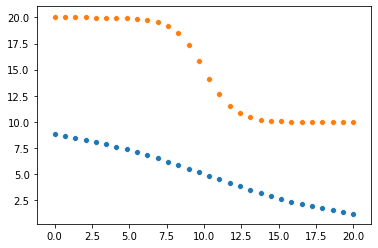

In [294]:
n_parts = 5

ka = np.zeros(n_parts)
ka[0] = 1

def sigmoid(x, a, kd, n, offset):
    return a - (a) / (1. + np.exp((-x + kd)*n)) + offset

x = np.linspace(0, 20, 30)
y = sigmoid(x, 10, 10, 0.2, 0)
sns.scatterplot(x=x, y=y)
x = np.linspace(0, 20, 30)
y = sigmoid(x, 10, 10, 1, 10)
sns.scatterplot(x=x, y=y)

(4, 20)


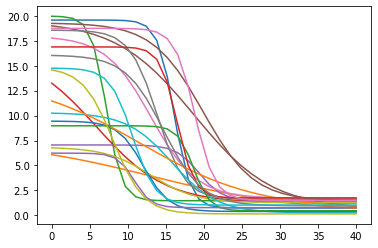

In [295]:
num = 20

A = np.random.uniform(5, 20, size=(num))
K = np.random.uniform(5, 20, size=(num))
n = np.random.uniform(0.1, 1, size=(num))
o = np.random.uniform(0, A.max() / 10., size=(num))

A = np.expand_dims(A, 1)
K = np.expand_dims(K, 1)
n = np.expand_dims(n, 1)
o = np.expand_dims(o, 1)

# [n_parts, n_params]
params = np.hstack([A, K, n, o])
print(params.T.shape)
x = np.repeat(np.expand_dims(np.linspace(0, 40, 30), 0), num, axis=0)
y = sigmoid(x, *tuple(np.expand_dims(params.T, 2)))

plt.plot(x.T, y.T);

In [296]:
import networkx as nx

g = nx.DiGraph()
g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
x = np.linspace(0, 30, 30)

def sigmoid_partial(x, node):
    return sigmoid(x, *tuple(np.expand_dims(params[node:node+1].T, 2)))


def steady_state(g, acc='sum', node_to_part = lambda x: int(x)):
    acc_dict = {
        'sum': lambda x: np.sum(np.concatenate(x))
    }
    
    # in topological order, we evaluate the sigmoid function at each node
    for node in nx.topological_sort(g):
        
        idx = node_to_part(node)
        # gather all parents
        # accumulate outputs 'y' using the provided accumulation function
        parents = list(g.predecessors(node))
        if not parents:
            p = np.expand_dims(params[idx:idx+1].T, 2)
            x = np.array([[0.]])
        else:
            a = []
            for p in parents:
                _x = g.nodes[p]['y']
                a.append(_x)
            x = acc_dict[acc](a)
            x = x.reshape(_x.shape)
        y = sigmoid_partial(x, idx)
#         if 'y' in g.nodes[node]:
#             g.nodes[node]['y'] += y
#         else:
        g.nodes[node]['y'] = y
        

for _ in range(5):
    steady_state(g, node_to_part = lambda x: int(x))
    out = []
    for n, ndata in g.nodes(data=True):
        out.append(ndata['y'])
    print(np.array(out).flatten())

[19.57752937  2.74553465 19.75155048  1.92022644]
[19.57752937  2.74553465 19.75155048  1.92022644]
[19.57752937  2.74553465 19.75155048  1.92022644]
[19.57752937  2.74553465 19.75155048  1.92022644]
[19.57752937  2.74553465 19.75155048  1.92022644]


In [297]:
from itertools import permutations
from typing import *
from functools import partial

def has_cycle(g):
    try:
        nx.find_cycle(g)
        return True
    except nx.NetworkXNoCycle:
        return False

def random_circuit(part_range):
    g = nx.DiGraph()
    n = np.random.randint(1, 10)
    nodes = np.random.randint(0, 20, size=(n, 3))
    for n1, n2 in permutations(nodes, r=2):
        if n1[-1] in (n2[0], n2[1]):
            g.add_edge(tuple(n1), tuple(n2))
    return g

def iter_random_circuit(limit, part_range: Tuple[int, int], cycles: bool = True):
    new_circuit = partial(random_circuit, part_range=part_range)
    for i in range(limit):
        c = new_circuit()
        if cycles is True:
            yield c
        else:
            while has_cycle(c):
                c = new_circuit()
            yield c

In [302]:
import torch
from tqdm.auto import tqdm
from torch_geometric.data import DataLoader

def add_features(g):
    new_g = nx.DiGraph()
    for n, data in g.nodes(data=True):
        new_g.add_node(n, **data)
    for n1, n2, edata in g.edges(data=True):
        edata['features'] = np.array([0.])
        print(edata)
        new_g.add_edge(n1, n2, **edata)
    steady_state(new_g, node_to_part= lambda x: x[-1])
    for n, ndata in new_g.nodes(data=True):
        ndata['features'] = torch.tensor(list(n), dtype=torch.float)
        ndata['target'] = torch.tensor([ndata['y'].flatten()], dtype=torch.float)
    return new_g
        
graphs = [add_features(g) for g in iter_random_circuit(3000, (2, 20), cycles=False)]

{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features': array([0.])}
{'features':

In [299]:
for _, _, edata in graphs[0].edges(data=True):
    print(edata)

{'features': array([0.])}
{'features': array([0.])}


In [300]:
to_graph_data(graphs[0])

(0, 1, {})


KeyError: 'features'